In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import math
from textstat import flesch_reading_ease
import random
from collections import defaultdict

## The instruction on where to get the data from is in Readme file. Download the data as instructed, decompress and place in NLP-LEGAL-EVAL directory (the same directory as the notebooks folder)

In [2]:
def prepareData(paths: list):
    files = []
    n_entries = 0
    for path in paths:
        with open(path, 'r') as f:
            file = json.load(f)
            files.append(file)
            n_entries += len(file)
    df = pd.DataFrame(columns=['text','results'], index = [x for x in range(n_entries)])
    num = 0
    for file in files:
        for row in file:
            df.loc[num] = pd.Series({"text": row['data']['text'], "results": [x['value'] for x in row['annotations'][0]['result']]})
            num += 1
    return df

In [3]:
data = prepareData(['../NER_TRAIN_PREAMBLE.json', '../NER_TRAIN_JUDGEMENT.json'])

In [4]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [5]:
def get_labels_with_corpus(data):
    labels = {}
    for i, row in data.iterrows():
        for d in row['results']:
            label = d['labels'][0]
            if label not in labels.keys():
                labels[label] = [row['text']]
            else:
                labels[label].append(row['text'])
    return labels

In [6]:
def get_labels_with_ner(data):
    labels = defaultdict(lambda: [])
    for i, row in data.iterrows():
        for d in row['results']:
            label = d['labels'][0]
            labels[label].append(d['text'])
    return labels

In [7]:
def top_ngrams_for_label(labels, n_gram_size=2):
    fig, axes = plt.subplots(2, 7, figsize=(30, 10))
    for i, label in enumerate(labels.keys()):
        top_ngrams_for_label = get_top_ngram(labels[label], n=n_gram_size)
        x,y=map(list,zip(*top_ngrams_for_label))
        sns.barplot(x=y,y=x, ax=axes[math.floor(i/7), i%7]).set_title(f"Top 10 {n_gram_size}-grams for label {label}")
    plt.tight_layout()
    plt.show()

In [8]:
def labels_hist(data):
    labels = {}
    for i, row in data.iterrows():
        for d in row['results']:
            label = d['labels'][0]
            if label not in labels.keys():
                labels[label] = [row['text']]
            else:
                labels[label].append(row['text'])
    x, y  = map(list, zip(*[(label, len(labels[label])) for label in labels.keys()]))
    fig, axes = plt.subplots(figsize=(15, 5))
    sns.barplot(x=x, y=y, ax=axes).set_title("Number of NER for each kind of them")
    plt.tight_layout()
    plt.show()

In [9]:
data.head()

,text,results
0,In The High Court Of Kerala At Ernakulam\n\nCr...,"[{'start': 7, 'end': 40, 'text': 'High Court O..."
1,In The Court Of Shri Lokesh Kumar Sharma\n ...,"[{'start': 21, 'end': 40, 'text': 'Lokesh Kuma..."
2,Before The Madurai Bench Of Madras High Court\...,"[{'start': 11, 'end': 45, 'text': 'Madurai Ben..."
3,Before The Madurai Bench Of Madras High Court\...,"[{'start': 11, 'end': 45, 'text': 'Madurai Ben..."
4,1 ...,"[{'start': 85, 'end': 119, 'text': 'High Court..."


Text(0.5, 1.0, 'Average number of words appearing in each text')

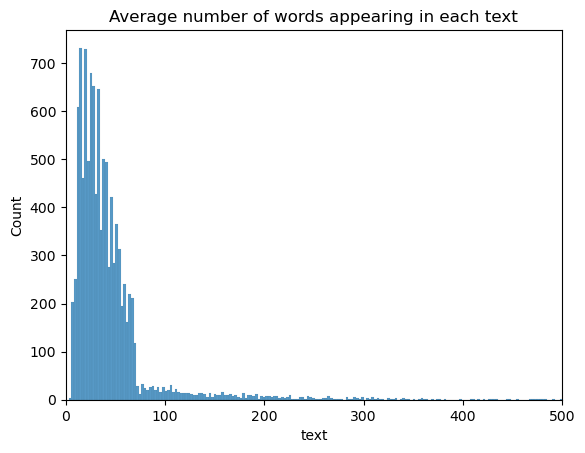

In [10]:
sent_len = data['text'].str.split().map(lambda x: len(x))
sns.histplot(sent_len)
plt.gca().set(xlim=(0, 500)) # set limit because there are some huge outliers
plt.title("Average number of words appearing in each text")

## We can see some weird outliers:
Bellow there is list of all textes with number of tokens over 600 and their NEs

In [11]:
for i, row in data[data['text'].str.split().str.len() > 600].iterrows():
    print("Next text")
    print("==================================================================================================")
    for d in row['results']:
        print(f"Label: {d['labels'][0]}\nNamed entity: {d['text']}\n")
    print(f"Text: {row['text']}")
    print("==================================================================================================")


Next text
Label: JUDGE
Named entity: Dama Seshadri Naidu

Label: PETITIONER
Named entity: Kondamudi Chandrasekhara Rao

Label: RESPONDENT
Named entity: State Bank of India, Zonal Office, Vijayawada

Label: LAWYER
Named entity: Challa Ajay Kumar

Label: LAWYER
Named entity: P.Vishnuvardhan Reddy

Label: JUDGE
Named entity: Dama Seshadri Naidu

Text: Honble Sri Justice Dama Seshadri Naidu          

Writ Petition Nos.6470 of  2006   

23-06-2014 

Kondamudi Chandrasekhara Rao..... Petitioner    

State Bank of India, Zonal Office, Vijayawada, rep. By its Assistant General
Manager nd others .....Respondents    Counsel for the petitioner:Sri Challa Ajay Kumar Counsel for respondents : Sri P.Vishnuvardhan Reddy Dr. Y.Padmavathi <Gist:
>Head Note: 
?Cases referred:
1. 1987(4) Scc 691 
2. Air 1966 Sc 1672 
3. 1993(1) Scc 71 
4. 2002(3) Llj 209
5. Air 1991 Sc 101 
6. Air 1986 Sc 954 
7. (1993) 1 Scc 71 
8. (1995) 2 Scc 326 
9. 1998(7) Scc 66 
10. 1997(7) Scc 592 
11. 1993(3) Scc 259 
12. Air 1

Text(0.5, 1.0, 'Everage word length in each sentence')

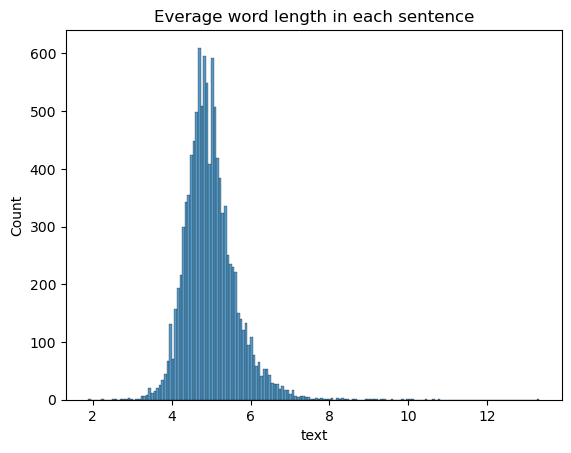

In [12]:
average_word_len = data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
sns.histplot(average_word_len)
plt.title("Everage word length in each sentence")

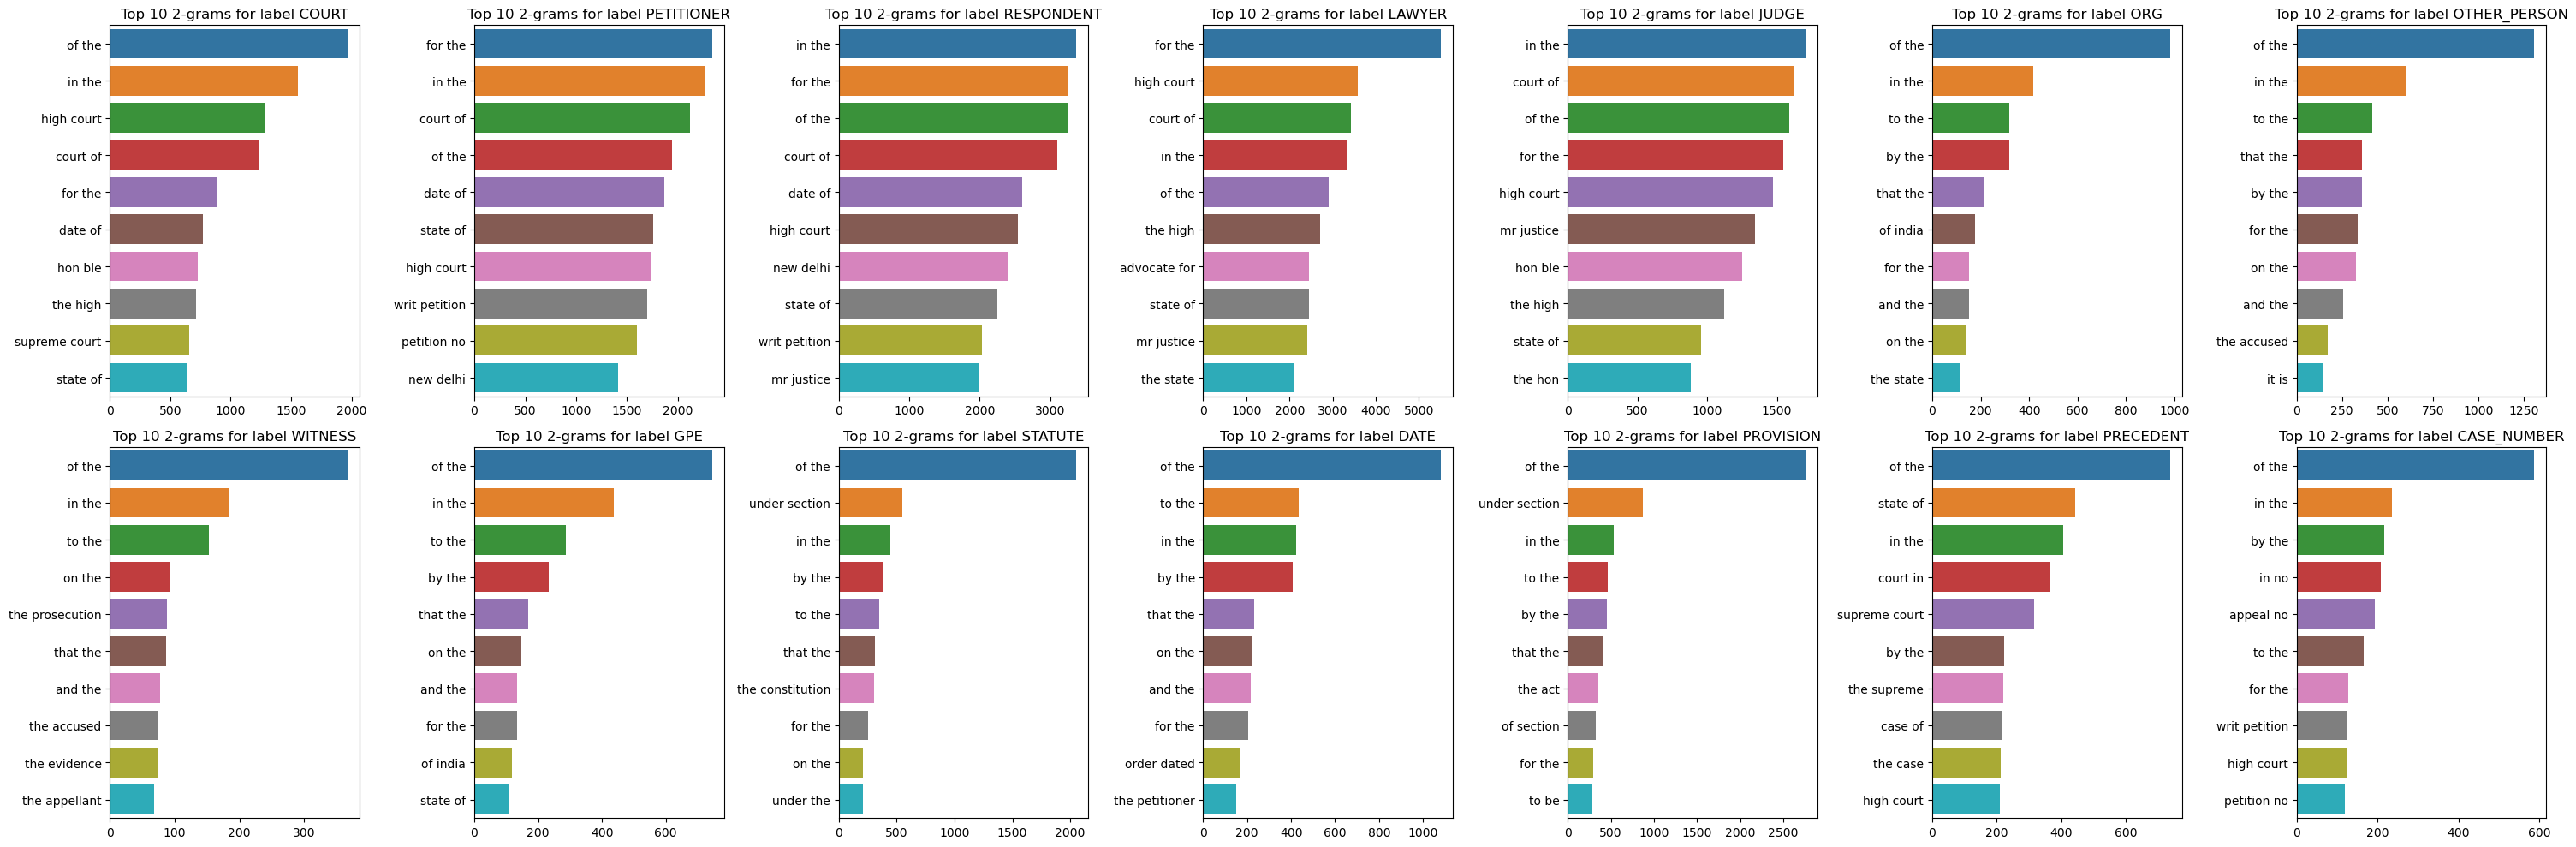

In [13]:
top_ngrams_for_label(get_labels_with_corpus(data), n_gram_size=2)


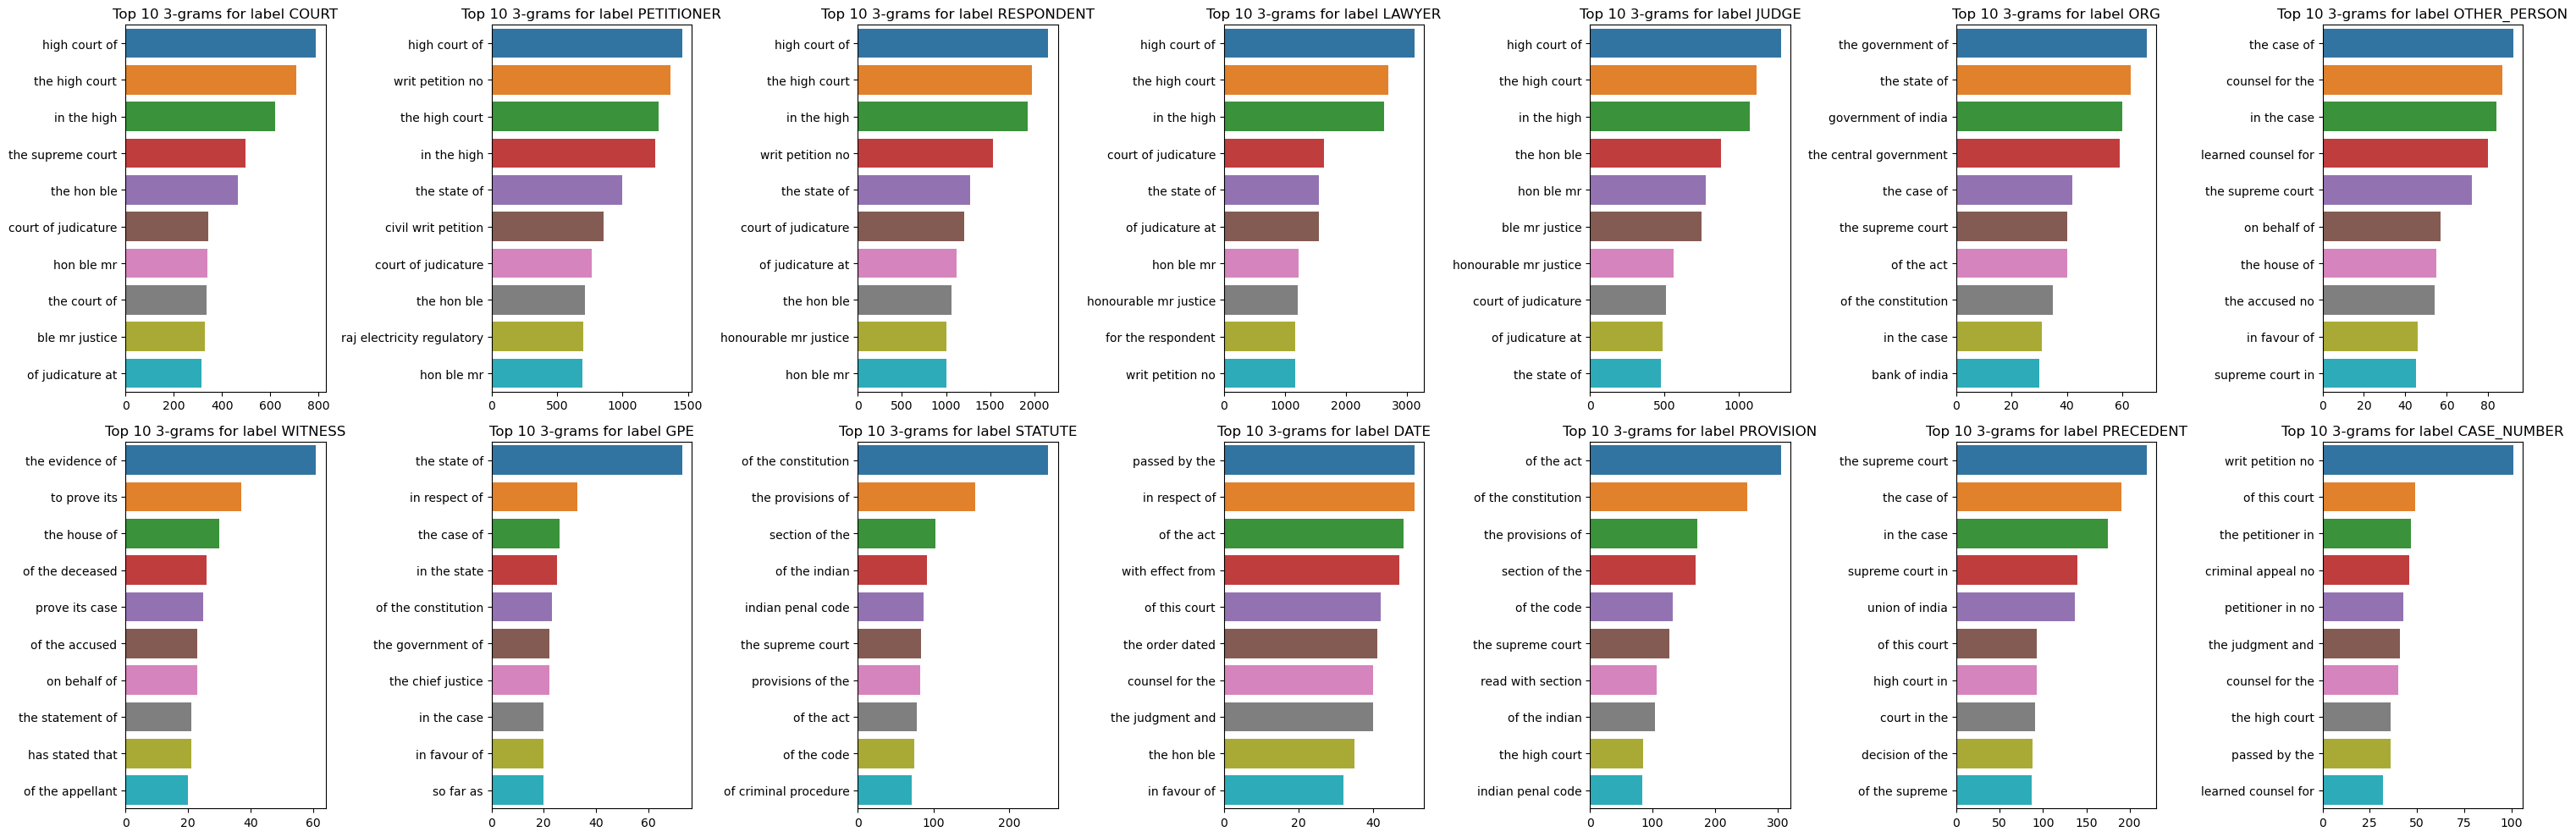

In [14]:
top_ngrams_for_label(get_labels_with_corpus(data), n_gram_size=3)

Let's do the same visualization with text text for labels beeing only NEs

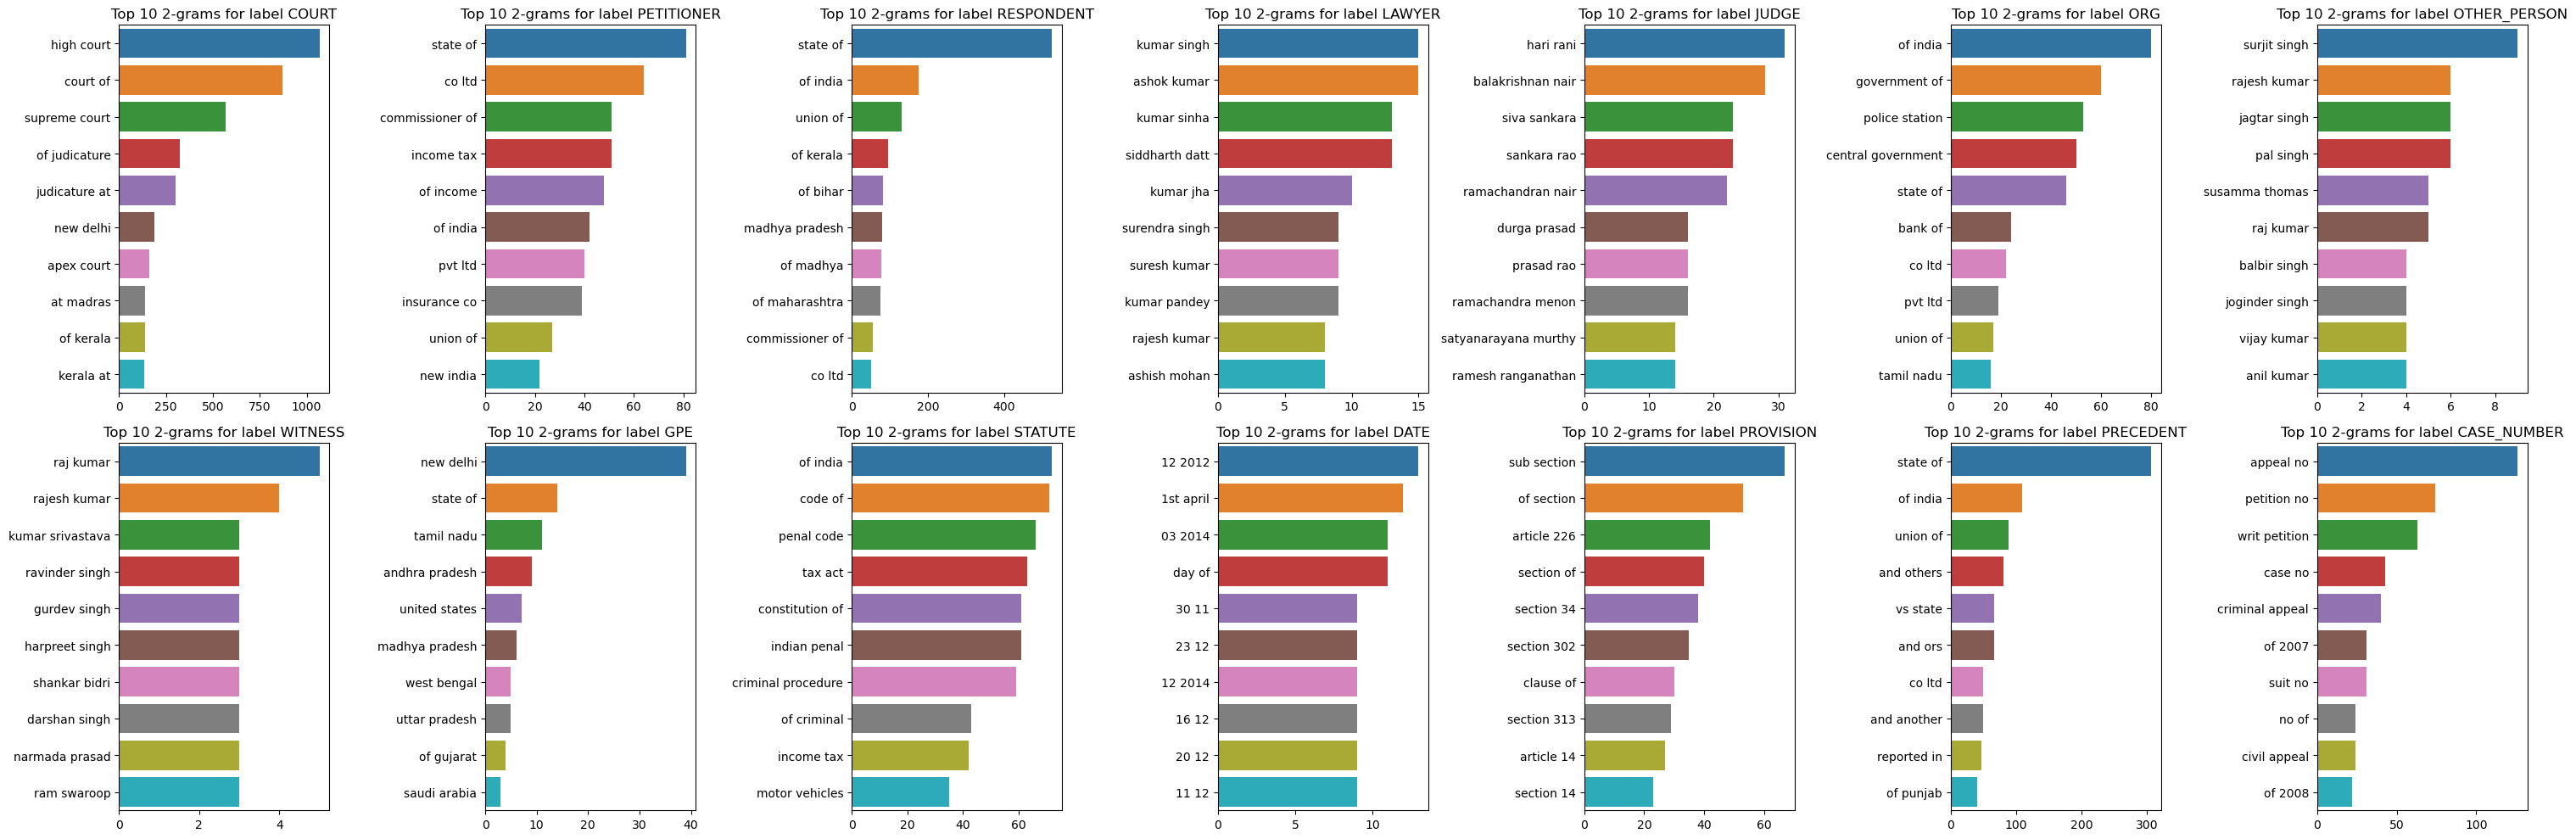

In [15]:
top_ngrams_for_label(get_labels_with_ner(data), n_gram_size=2)

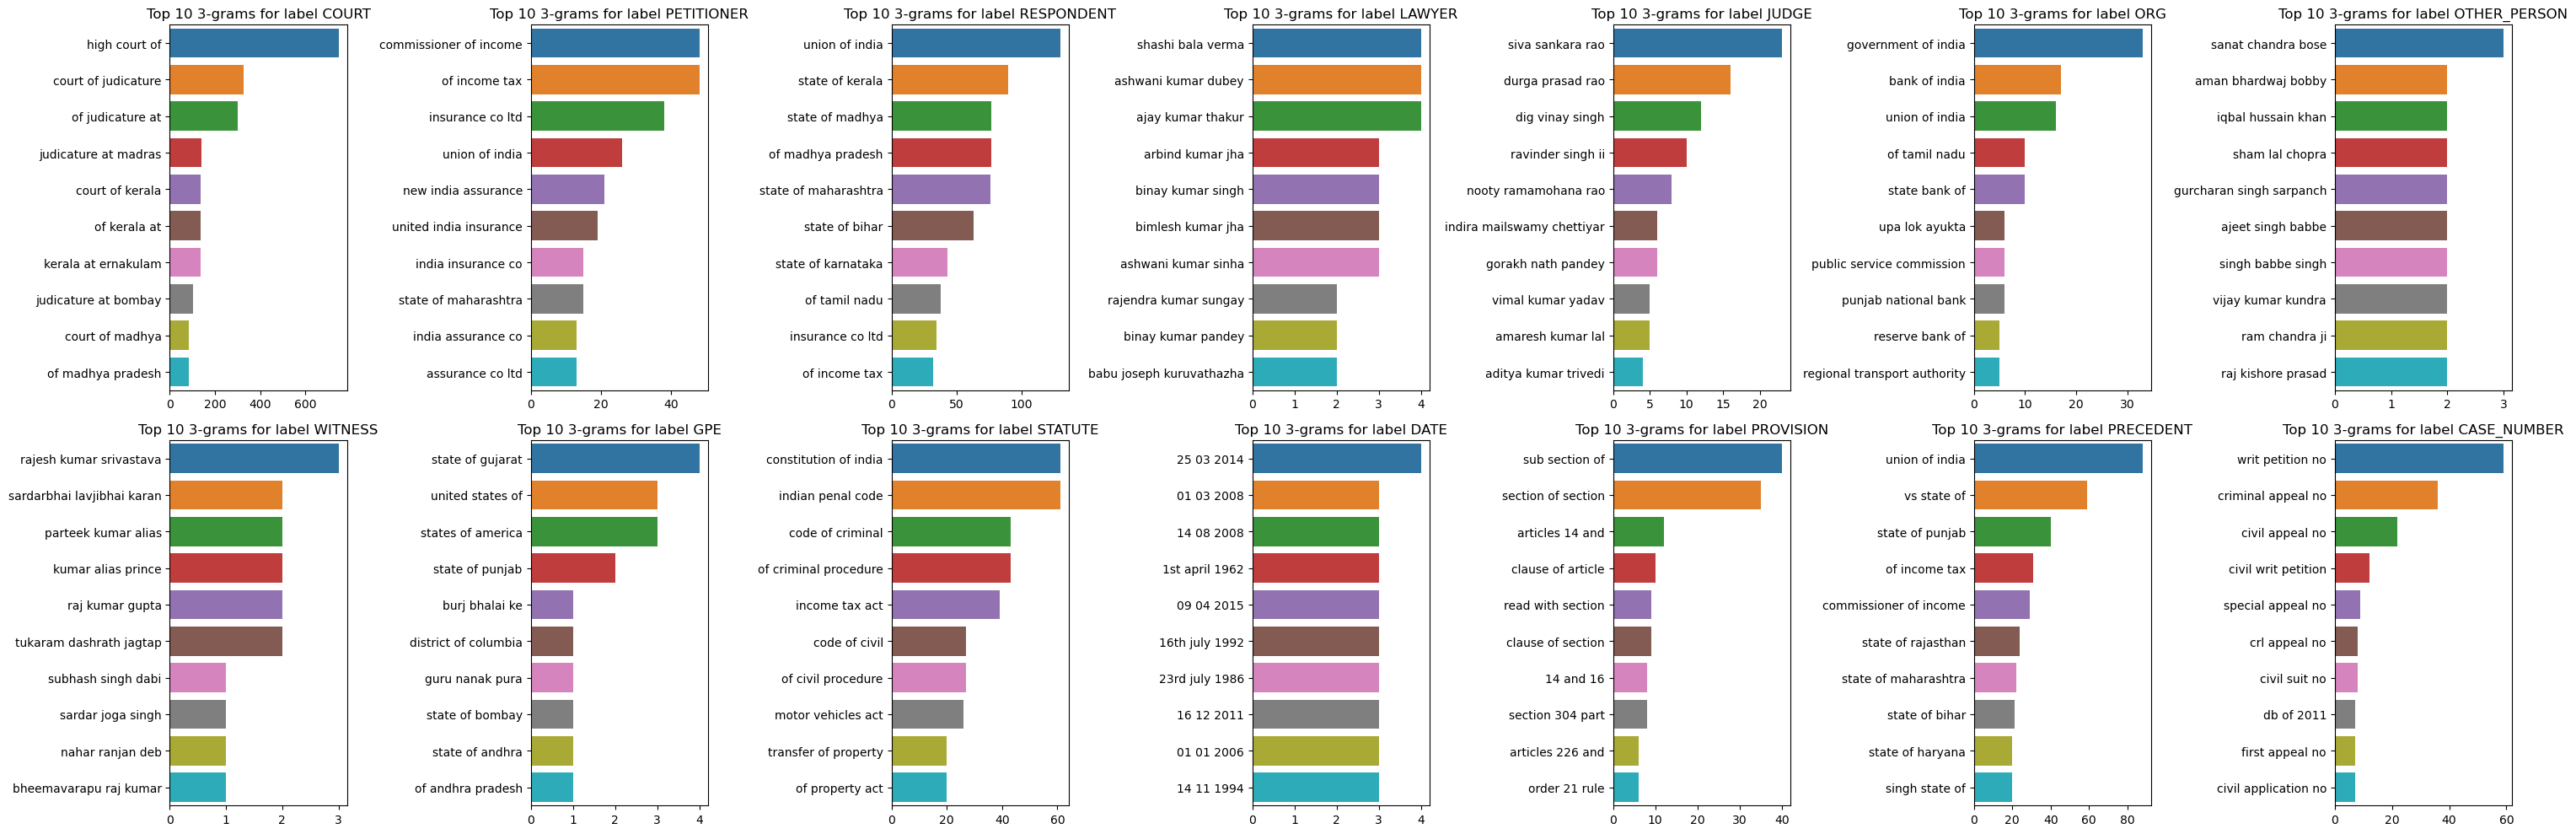

In [16]:
top_ngrams_for_label(get_labels_with_ner(data), n_gram_size=3)

Text(0.5, 1.0, 'Flesch Reading Ease Scores')

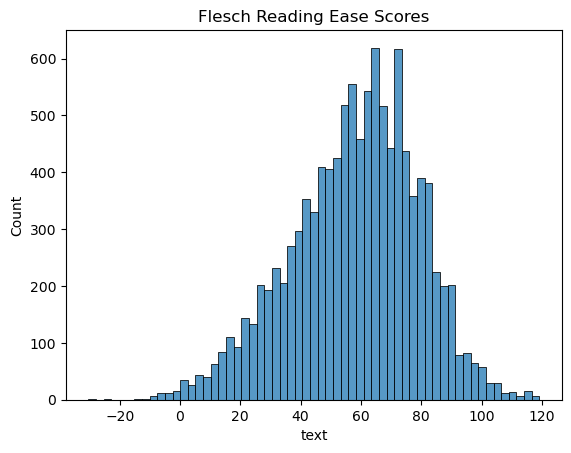

In [17]:
flesch_scores = data['text'].apply(lambda x: flesch_reading_ease(x))
sns.histplot(flesch_scores)
plt.title('Flesch Reading Ease Scores')

## Surprisingly majority of the querries is easy to read

FRE = 206.835 − 1.015 * (total words/total sentences)rn− 84.6 * (total syllables/ total words)

Higher scores indicate material that is easier to read,

lower numbers mark harder-to-read passages:

rn– 0-30 College 

rn– 50-60 High school

rn– 60+ Fourth grade

### Let's project the hardest ones:

In [18]:
random.seed(10)
x = [i for i in range(len(flesch_scores)) if flesch_scores[i]<10]
hard_to_read = data.iloc[x]
for x in range(4):
    print("Sentence number", x)
    print(hard_to_read.iloc[random.randint(0, len(hard_to_read))]['text'], end='\n\n')

Sentence number 0
In India, as has been shown there is a statutory right on the part of the police to investigate the circumstances of an alleged cognizable crime without requiring any authority from the judicial authorities, and it would, at their Lordships think, be an unfortunate result if it should be held possible to interfere with those statutory rights by an exercise of the inherent jurisdiction of the Court."

Sentence number 1
The above observations of the Tribunal made on the basis of the observations of the Supreme Court in Sahney Steel also how that the Tribunal was alive to the distinction between the character of the subsidy given with the object of promoting industrial growth in a particular area and the subsidy given conditional upon the commencement of production and after actual commencement of production.

Sentence number 2
Specific reference has been made to Krishena Kumar's case, supra, Indian Ex-Services League v Union of India, All India Reserve Bank Retired Offi

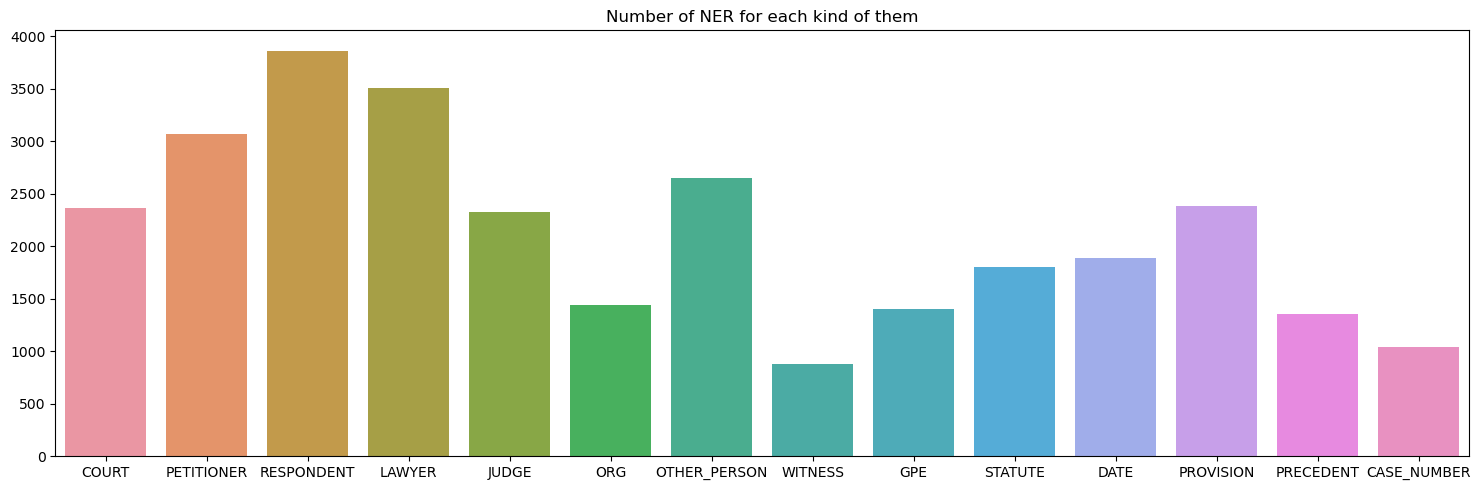

In [19]:
labels_hist(data)

### Detecting a witness might be tricky